In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import time

from scipy.stats.stats import pearsonr

from matplotlib import cm
import pickle


## Place cell class

In [4]:
class PlaceCell(object):

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):
        xm = x - self.mu
        sigma = self.sigma
        
        factor1 = 4            # peak firing rate
        factor2 = (np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm))
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
        activity = np.random.poisson(self.gaussian(x))

        return activity

# Tool functions

## Color plot

In [5]:
def colormapLocation(coordinates, height = 140, width = 140):

    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)
    normX, normY = normalizeX(coordinates[0,:]), normalizeY(coordinates[1,:])

    # mapX = cm.get_cmap('Blues')
    # mapY = cm.get_cmap('Reds')
    mapX = cm.get_cmap('binary')
    mapY = cm.get_cmap('spring')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)
    colorValues = (colorValues_X + colorValues_Y)/2

    return colorValues

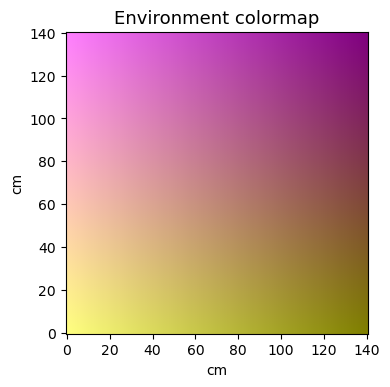

In [6]:
def plotColormapEnvironment(height = 140, width = 140):

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            dataLocation.append(location)

    colormap = colormapLocation(np.hstack(dataLocation))
    environmentColorMap = colormap.reshape(yLen, xLen, 4)       ### I am very confused by the orther of the dimensions now

    plt.figure(dpi=100)
    plt.clf()
    plt.imshow(environmentColorMap)

    ## Run the code without the ticks. Then, it chooses strange numbers for x-axis. There is also a minor problem with 140 tick. There is originally 141 coordinates for both axes
    plt.xticks([0,20,40,60,80,100,120,140])
    plt.yticks([0,20,40,60,80,100,120,140], [140,120,100,80,60,40,20,0])

    plt.title("Environment colormap", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.show()
    pass

plotColormapEnvironment()

## Place field plot function

In [7]:
def plotCells(cellList, height= 140, width= 140):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            location = np.array([[x_coordinates[x]],                    # important to be careful about the indexing
                                 [y_coordinates[y]]])
            
            for placeCell in cellList:
                locationActivity = placeCell.activity(location)

                if Z[y][x] < locationActivity:
                    Z[y][x] = locationActivity

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.title(str(len(cellList)) + " place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass

In [54]:
def plotActivity(master_activity_plot_list, n_neurons, experiment):

    cellActivity = master_activity_plot_list[n_neurons][experiment]
    number_of_neurons = (n_neurons+1)*10

    x_coordinates = np.arange(start=0, stop= 140 +1, step=1)
    y_coordinates = np.arange(start=0, stop= 140 +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = cellActivity

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.title(str(number_of_neurons) + " place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass
    pass

In [9]:
def plot_embedding(embedding, color):
    
    embeding_transpose = embedding.T

    plt.figure(dpi=100)    # figsize=(width, height)
    plt.scatter(embeding_transpose[:, 0], embeding_transpose[:, 1], c= colormapLocation(color))

    plt.title(("? embedding of " + str("n") + " cells over " + str(int(embedding.shape[1]/600)) + " minutes"), size= 13)
    plt.xlabel("a.u.")
    plt.ylabel("a.u.")

    plt.gca().set_aspect('equal', 'datalim')
    

    pass

In [120]:
def correlationMean(correlation_list):
    correlation_array = np.row_stack(correlation_list)
    correlation_array_fisherz = np.arctanh(correlation_array)
    correlation_mean_fisherz = np.mean(correlation_array_fisherz, 0)
    correlation_mean = np.tanh(correlation_mean_fisherz)


    correlation_std_fisherz = np.std(correlation_array_fisherz, 0)
    upper_limit_fisherz = correlation_mean_fisherz + correlation_std_fisherz
    lower_limit_fisherz = correlation_mean_fisherz - correlation_std_fisherz

    upper_limit = np.tanh(upper_limit_fisherz)
    lower_limit = np.tanh(lower_limit_fisherz)


    # correlation_std = np.tanh(correlation_std_fisherz)

    return correlation_mean, upper_limit, lower_limit

In [103]:
def plot_corr_over_time(main_itteration, n_cells):                           # i

    time = (5, 10, 15, 20, 25, 30)
    pca_correlation = []
    laplacian_correlation = []
    umap_correlation = []

    for experiment in main_itteration:                              # j

        experiment_pca_correlation = []
        experiment_laplacian_correlation = []
        experiment_umap_correlation = []

        for t_time in experiment:                           # k

            real_distance = t_time[0][1]
            pca_distance = t_time[1][1]
            laplacian_distance = t_time[2][1]
            umap_distance = t_time[3][1]

            pearson_pca = pearsonr(real_distance, pca_distance)[0]
            experiment_pca_correlation.append(pearson_pca)

            pearson_laplacian = pearsonr(real_distance, laplacian_distance)[0]
            experiment_laplacian_correlation.append(pearson_laplacian)

            pearson_umap = pearsonr(real_distance, umap_distance)[0]
            experiment_umap_correlation.append(pearson_umap)

        pca_correlation.append(experiment_pca_correlation)
        laplacian_correlation.append(experiment_laplacian_correlation)
        umap_correlation.append(experiment_umap_correlation)


    pca_correlation_mean = correlationMean(pca_correlation)[0]
    pca_upper_limit = correlationMean(pca_correlation)[1]
    pca_lower_limit = correlationMean(pca_correlation)[2]
    # pca_correlation_mean_std = correlationMean(pca_correlation)[1]

    laplacian_correlation_mean = correlationMean(laplacian_correlation)[0]
    laplacian_upper_limit = correlationMean(laplacian_correlation)[1]
    laplacian_lower_limit = correlationMean(laplacian_correlation)[2]
    # laplacian_correlation_mean_std = correlationMean(laplacian_correlation)[1]

    umap_correlation_mean = correlationMean(umap_correlation)[0]
    umap_upper_limit = correlationMean(umap_correlation)[1]
    umap_lower_limit = correlationMean(umap_correlation)[2]
    # umap_correlation_mean_std = correlationMean(umap_correlation)[1]
    # error_bars = [umap_lower_limit, umap_upper_limit]


    plt.figure(dpi=100)
    plt.title((str(n_cells) + " neurons"), size= 15)
    plt.xlabel("minutes", size= 13)
    plt.ylabel("correlation coefficient average", size= 13)
    plt.grid()
    plt.xlim([4.2, 30.8])
    plt.ylim([-0.1, 1.15])
    

    plt.plot(time, pca_correlation_mean, marker='o')
    plt.fill_between(time, pca_lower_limit, pca_upper_limit, alpha=0.3)
    # plt.errorbar(time, pca_correlation_mean, pca_correlation_mean_std)

    plt.plot(time, laplacian_correlation_mean, marker='o')
    plt.fill_between(time, laplacian_lower_limit, laplacian_upper_limit, alpha=0.3)
    # plt.errorbar(time,laplacian_correlation_mean, laplacian_correlation_mean_std)
    
    plt.plot(time, umap_correlation_mean, marker='o')
    plt.fill_between(time, umap_lower_limit, umap_upper_limit, alpha=0.3)
    # plt.errorbar(time, umap_correlation_mean, error_bars)

    plt.legend(['PCA', 'Laplacian Eigenmaps', 'UMAP'], ncol=3, bbox_to_anchor=(0.5, 1), loc='upper center')

    pass


In [127]:
def plot_corr_over_cells(master_data_set, t_time):

    time = (t_time + 1) * 5

    neurons = []
    for i in range(10, 310, 10):
        neurons.append(i)

    pca_correlation = []
    pca_upper_limit = []
    pca_lower_limit = []

    laplacian_correlation = []
    laplacian_upper_limit = []
    laplacian_lower_limit = []

    umap_correlation = []
    umap_upper_limit = []
    umap_lower_limit = []


    for experiment in master_data_set:


        pca_correlation_per_experiments = []
        laplacian_correlation_per_experiments = []
        umap_correlation_per_experiments = []

        for trial in experiment:

            pearson_pca = pearsonr(trial[t_time][1][1], trial[t_time][0][1])[0]
            pca_correlation_per_experiments.append(pearson_pca)

            pearson_laplacian = pearsonr(trial[t_time][2][1], trial[t_time][0][1])[0]
            laplacian_correlation_per_experiments.append(pearson_laplacian)

            pearson_umap = pearsonr(trial[t_time][3][1], trial[t_time][0][1])[0]
            umap_correlation_per_experiments.append(pearson_umap)

        pca_correlation.append(correlationMean(pca_correlation_per_experiments)[0])
        pca_upper_limit.append(correlationMean(pca_correlation_per_experiments)[1])
        pca_lower_limit.append(correlationMean(pca_correlation_per_experiments)[2])

        laplacian_correlation.append(correlationMean(laplacian_correlation_per_experiments)[0])
        laplacian_upper_limit.append(correlationMean(laplacian_correlation_per_experiments)[1])
        laplacian_lower_limit.append(correlationMean(laplacian_correlation_per_experiments)[2])

        umap_correlation.append(correlationMean(umap_correlation_per_experiments)[0])
        umap_upper_limit.append(correlationMean(umap_correlation_per_experiments)[1])
        umap_lower_limit.append(correlationMean(umap_correlation_per_experiments)[2])

    print(len(pca_correlation))
    print(pca_lower_limit[0])

    plt.figure(dpi=100, figsize=(20, 3.7))

    plt.title((str(time) + " minutes"), size= 15)

    plt.xlabel("number of neurons", size= 13)
    plt.xticks(np.arange(10, 310, 10))
    plt.ylabel("correlation coefficient average", size= 13)
    plt.grid()

    plt.xlim([8, 302])
    plt.ylim([-0.05, 1.12])

    plt.plot(neurons, pca_correlation, marker='o')
    # plt.fill_between(neurons, pca_lower_limit, pca_upper_limit, alpha=0.3)

    plt.plot(neurons, laplacian_correlation, marker ='o')
    # plt.fill_between(neurons, laplacian_lower_limit, laplacian_upper_limit, alpha=0.3)

    plt.plot(neurons, umap_correlation, marker='o')
    # plt.fill_between(neurons, umap_lower_limit, umap_upper_limit, alpha=0.3)

    plt.legend(['PCA', 'Laplacian Eigenmaps', 'UMAP'], ncol=3, bbox_to_anchor=(0.5, 1.019), loc='upper center')




# Data analysis

In [11]:
master_data_set = pickle.load(open("master_data_list.pickle", "rb"))
master_cells_set = pickle.load(open("master_cell_list.pickle", "rb"))
master_activity_plot_list = pickle.load(open("master_activity_plot_list.pickle", "rb"))

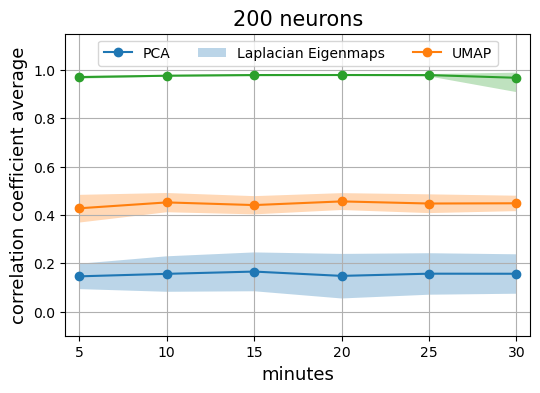

In [107]:
for i in range(19,20):
    plot_corr_over_time(master_data_set[i], (i+1)*10)

30
[-0.07681416]
30
[-0.0440586]
30
[-0.04865089]
30
[-0.06028787]
30
[-0.07209495]
30
[-0.0855029]


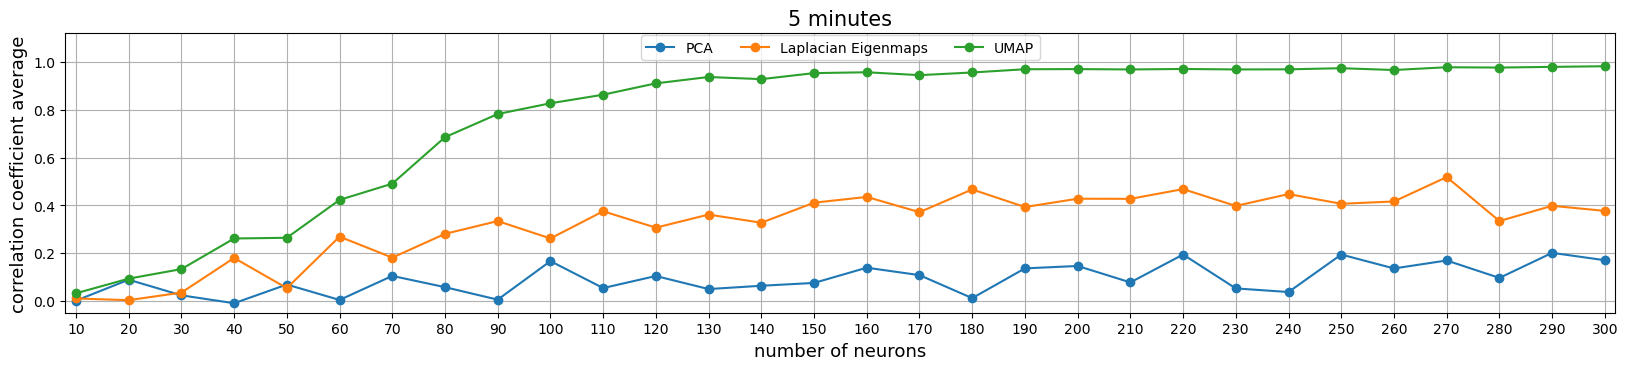

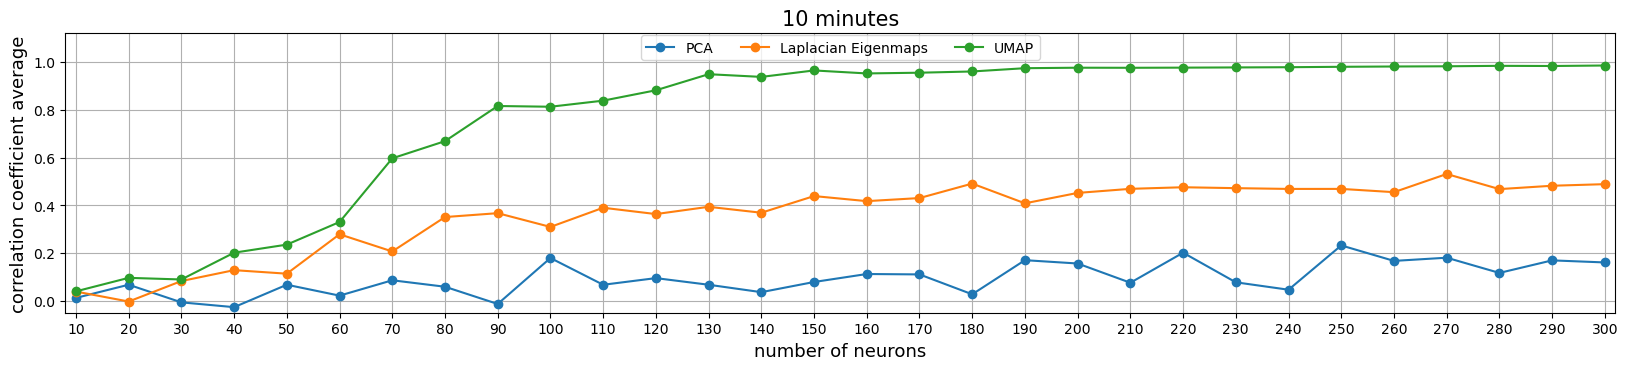

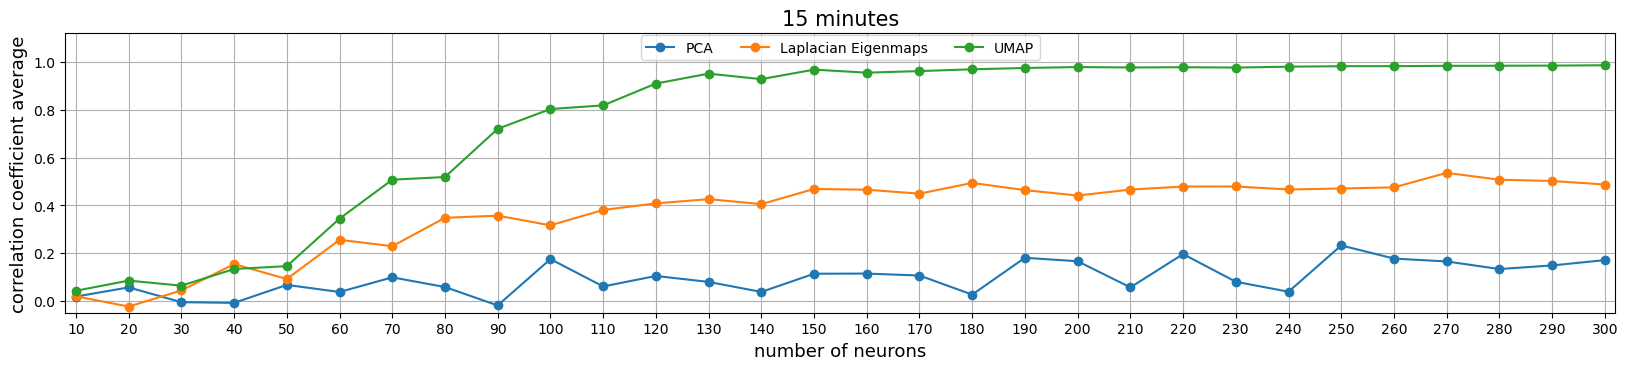

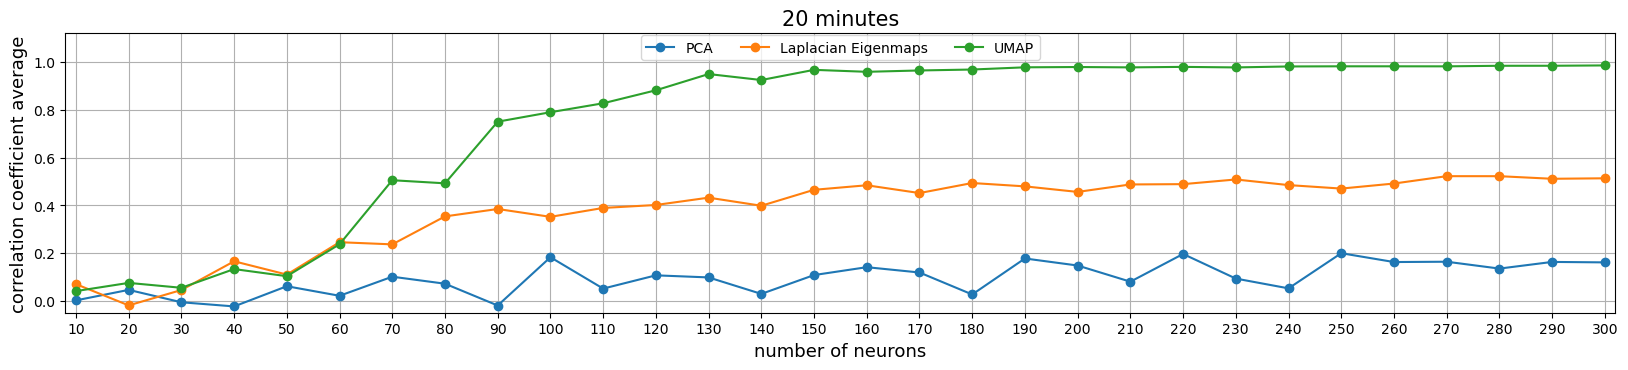

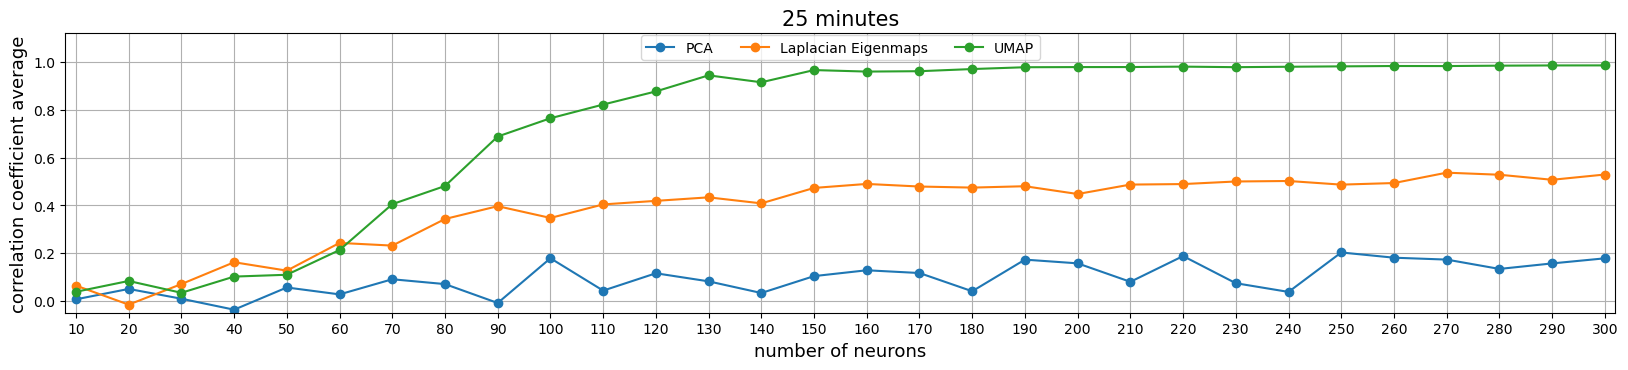

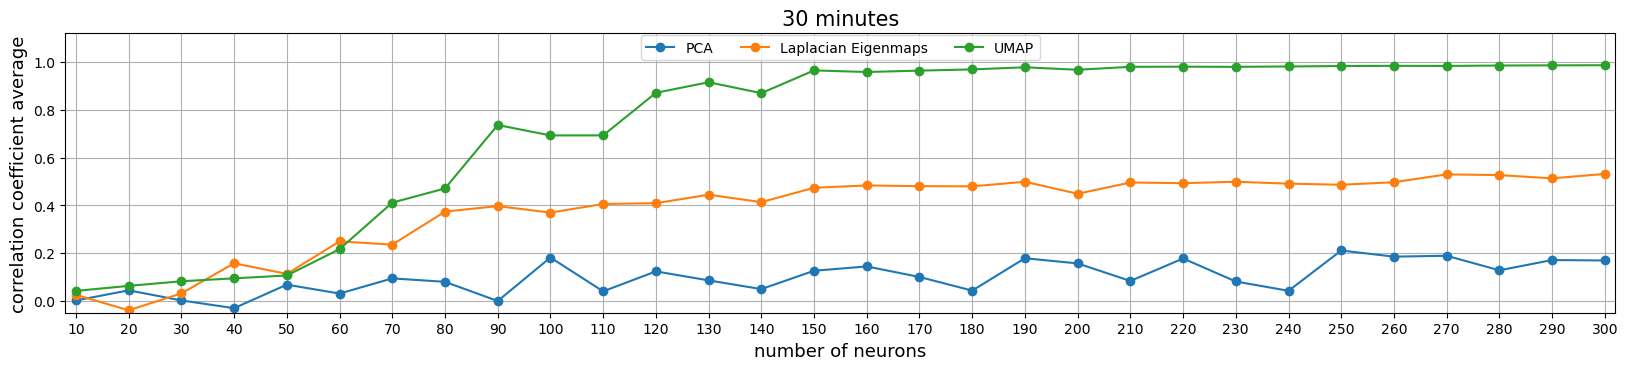

In [128]:
for i in range(0,6):
    plot_corr_over_cells(master_data_set, i)

In [ ]:
plot_embedding()

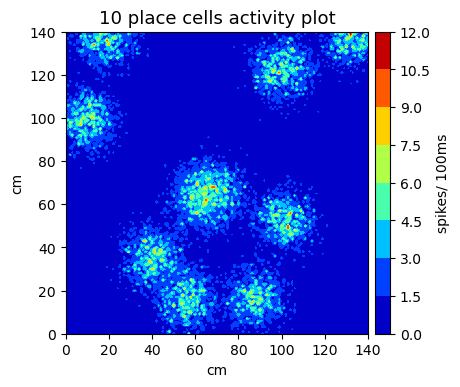

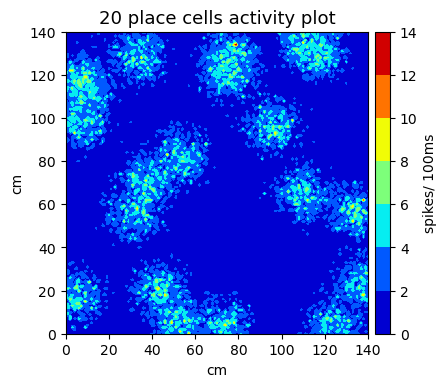

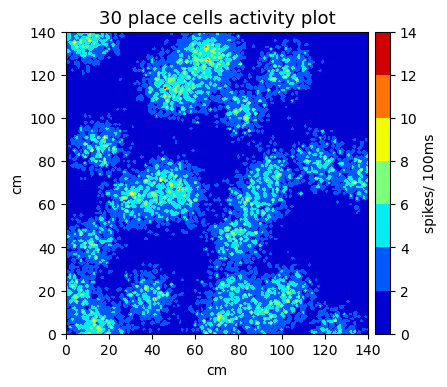

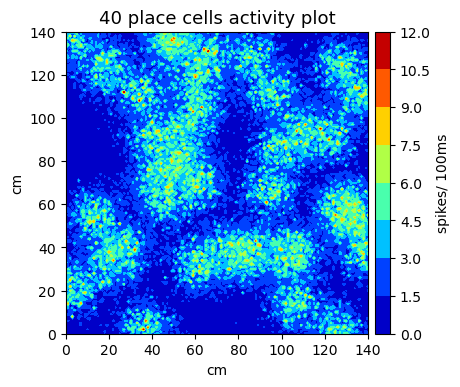

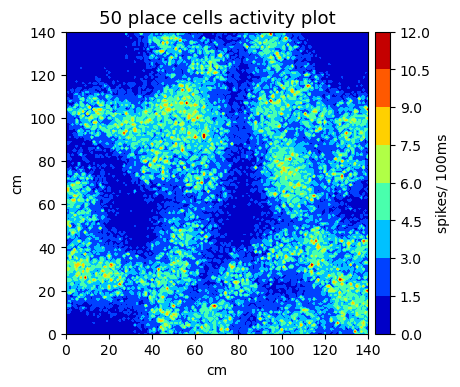

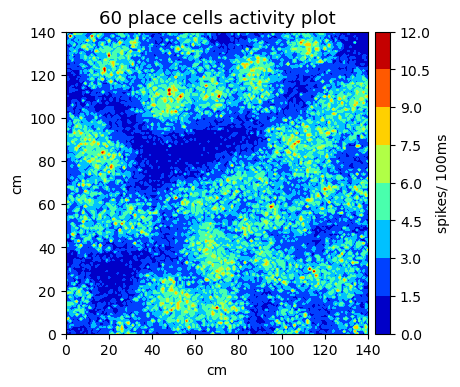

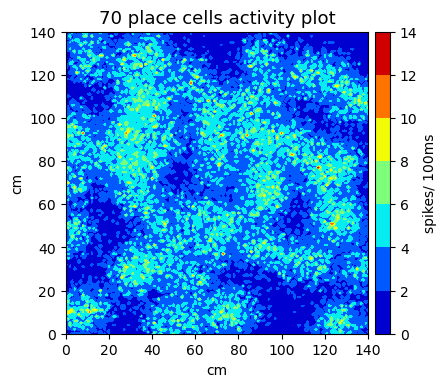

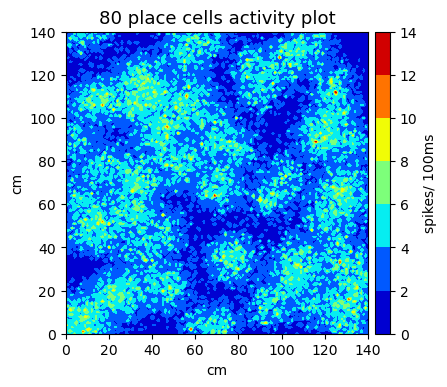

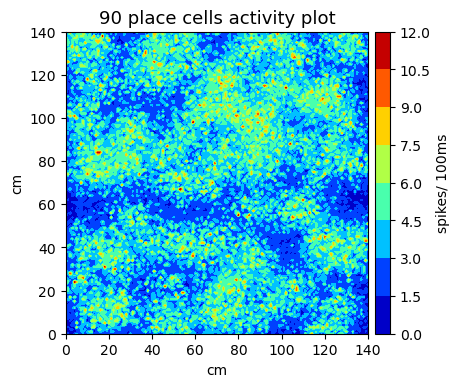

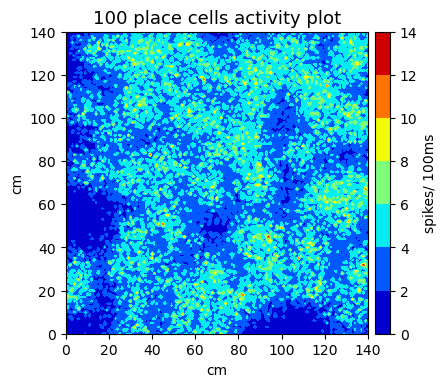

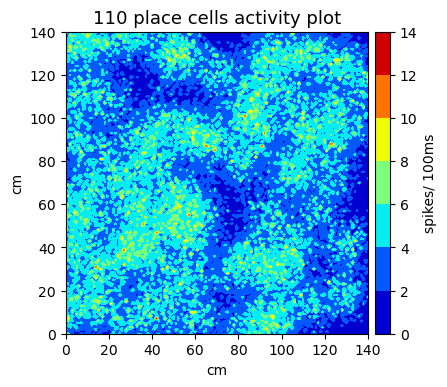

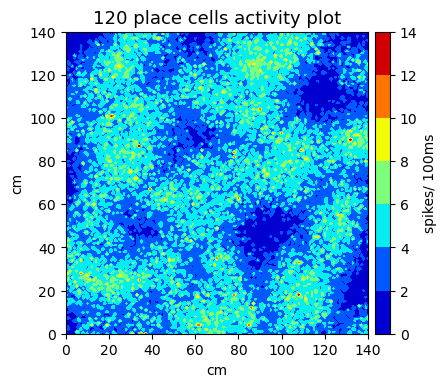

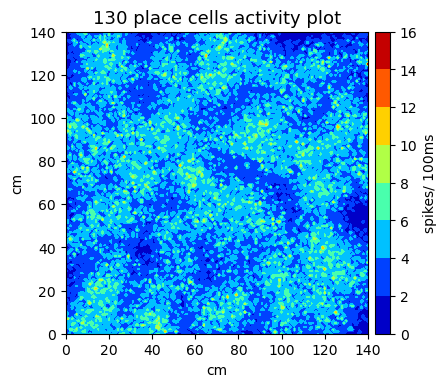

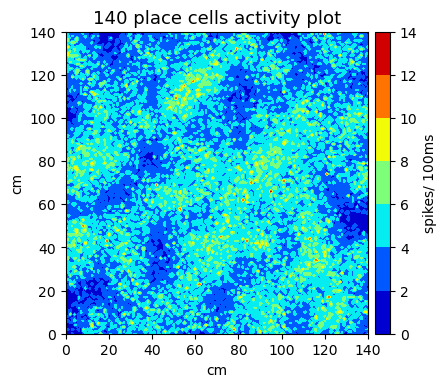

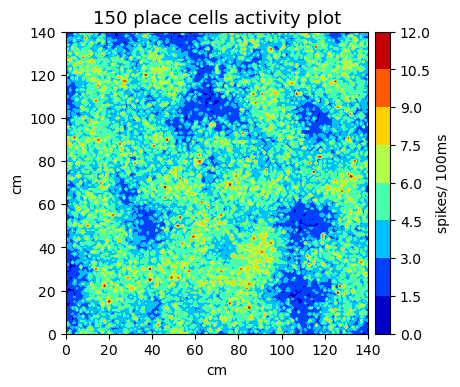

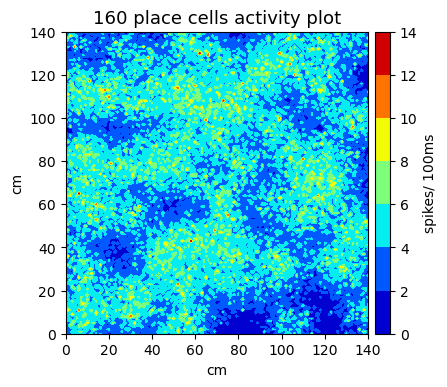

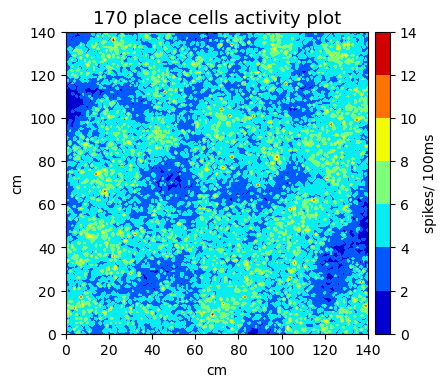

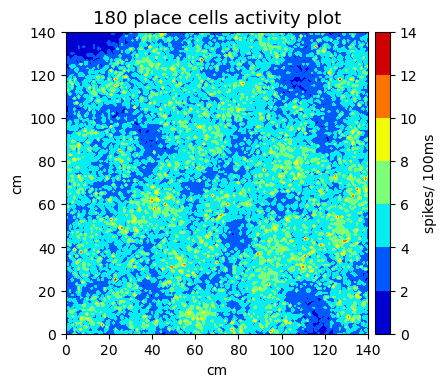

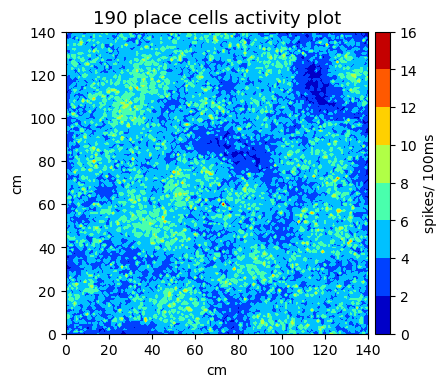

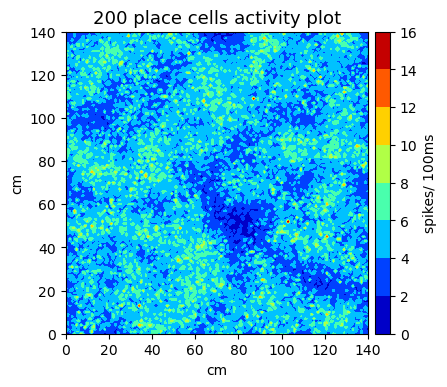

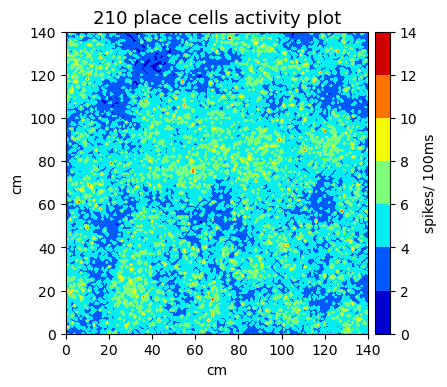

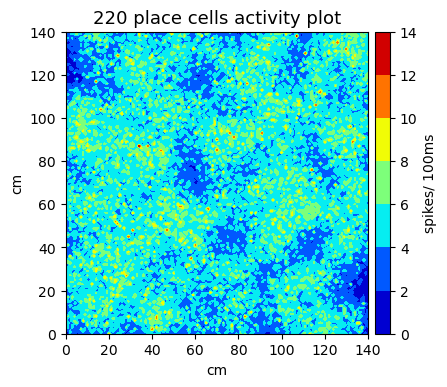

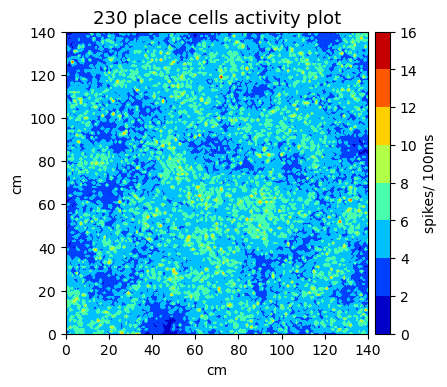

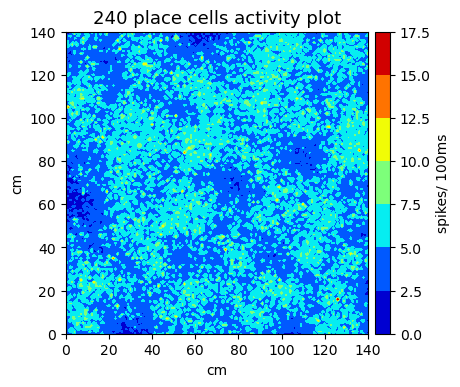

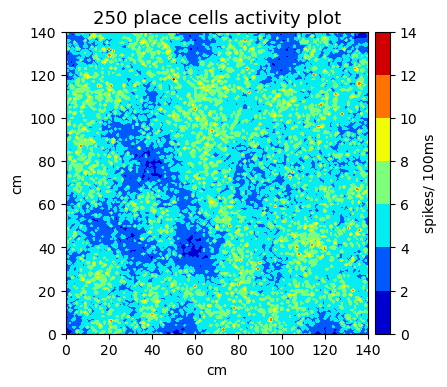

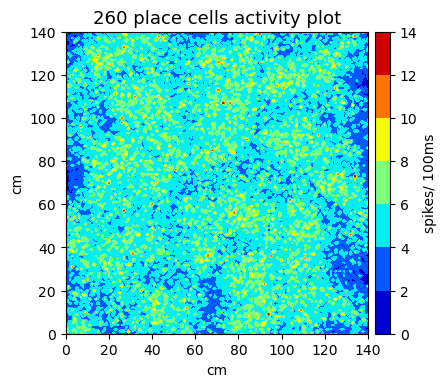

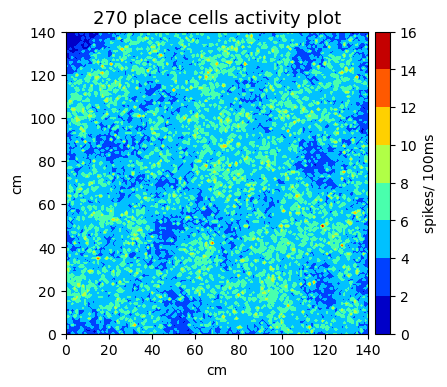

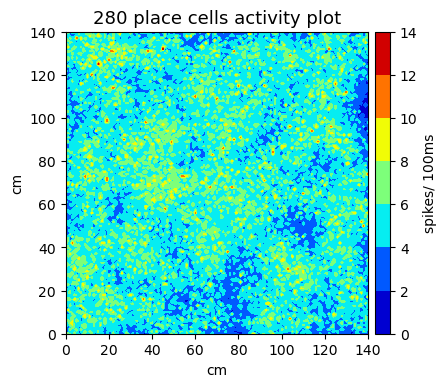

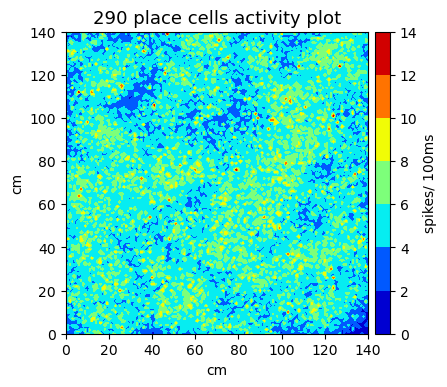

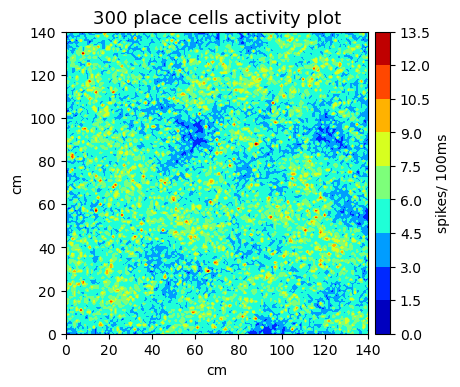

In [60]:
for i in range(30):

    plotActivity(master_activity_plot_list, i, 0)


# Notes, comments, old code, etc

In [89]:
# cell_activity_plot_list = []

# num = 1

# for i in master_cells_set:
#     print("loop n:", num, "initiated")
#     inner_list = []
#     for j in i:
#         activity_plot = plotCells(j)
#         inner_list.append(activity_plot)
    
#     cell_activity_plot_list.append(inner_list)

#     num += 1

# print("all done")
